## Data Exploration
### Data from LTA Datamall and Land Transport Guru (https://landtransportguru.net/train/tel/)

This notebook was used to do Explortary Data Analysis to have a general understanding of the problem.

In [6]:
import geopandas
import os
import re
import pandas as pd
import json
import folium
import requests
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import seaborn as sns

In [7]:
key = os.environ.get("LTA_API_KEY")

In [ ]:
ridership = pd.read_csv('../data/monthly_ave_daily_pt_ridership.csv')
ridership.head()

,month,mode,ridership
0,Jan-19,MRT,3462000
1,Jan-19,LRT,218000
2,Jan-19,Public Bus,4250000
3,Feb-19,MRT,3248000
4,Feb-19,LRT,206000


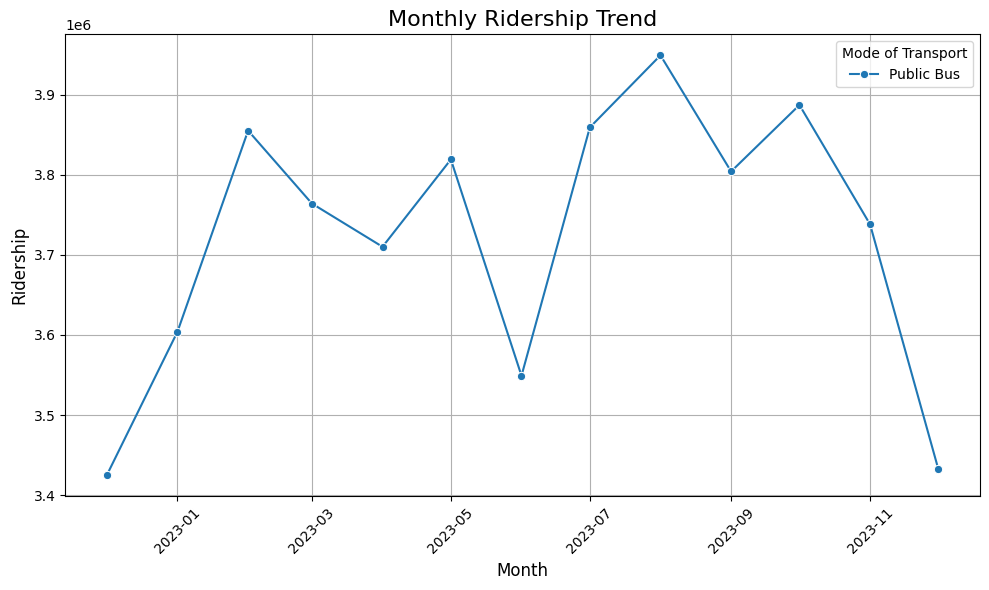

In [9]:
# Filter the data for the last 2 years
ridership['month'] = pd.to_datetime(ridership['month'], format='%b-%y')
last_5_years = ridership['month'].max() - pd.DateOffset(years=1)
ridership_last_5_years = ridership[ridership['month'] >= last_5_years]
ridership_last_5_years = ridership_last_5_years[ridership_last_5_years['mode'] == 'Public Bus']

# Group the data by 'month' and 'mode' to calculate the total ridership per mode
ridership_trends = ridership_last_5_years.groupby(['month', 'mode']).sum().reset_index()

# Create a line plot to visualize ridership trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=ridership_trends, x='month', y='ridership', hue='mode', marker='o')

# Customize plot labels and title
plt.title('Monthly Ridership Trend', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Ridership', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Mode of Transport')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

#### Bus Routes

In [10]:
def call_busroutes_api():

    url = "https://datamall2.mytransport.sg/ltaodataservice/BusRoutes"

    payload = {}
    headers = {
    'AccountKey': key,
    'Accept': 'application/json'
    }

    response = requests.request("GET", url, headers=headers, data=payload)
    return response.json()['value']

bus_routes = call_busroutes_api()

print(bus_routes)


[{'ServiceNo': '10', 'Operator': 'SBST', 'Direction': 1, 'StopSequence': 1, 'BusStopCode': '75009', 'Distance': 0, 'WD_FirstBus': '0500', 'WD_LastBus': '2300', 'SAT_FirstBus': '0500', 'SAT_LastBus': '2300', 'SUN_FirstBus': '0500', 'SUN_LastBus': '2300'}, {'ServiceNo': '10', 'Operator': 'SBST', 'Direction': 1, 'StopSequence': 2, 'BusStopCode': '76059', 'Distance': 0.6, 'WD_FirstBus': '0502', 'WD_LastBus': '2302', 'SAT_FirstBus': '0502', 'SAT_LastBus': '2302', 'SUN_FirstBus': '0502', 'SUN_LastBus': '2302'}, {'ServiceNo': '10', 'Operator': 'SBST', 'Direction': 1, 'StopSequence': 3, 'BusStopCode': '76069', 'Distance': 1.1, 'WD_FirstBus': '0504', 'WD_LastBus': '2304', 'SAT_FirstBus': '0504', 'SAT_LastBus': '2304', 'SUN_FirstBus': '0503', 'SUN_LastBus': '2304'}, {'ServiceNo': '10', 'Operator': 'SBST', 'Direction': 1, 'StopSequence': 4, 'BusStopCode': '96289', 'Distance': 2.3, 'WD_FirstBus': '0508', 'WD_LastBus': '2308', 'SAT_FirstBus': '0508', 'SAT_LastBus': '2309', 'SUN_FirstBus': '0507', '

#### Bus Stops

In [11]:
def call_busstops_api(data_variable):
    url = "https://datamall2.mytransport.sg/ltaodataservice/BusStops"

    payload = {}
    headers = {
    'AccountKey': key,
    'Accept': 'application/json'
    }

    response = requests.request("GET", url, headers=headers, data=payload)

    bus_stops = response.json()['value']
    return [stop[str(data_variable)] for stop in bus_stops]

bus_stop_codes = call_busstops_api('BusStopCode')
bus_stop_names = call_busstops_api('Description')
print(bus_stop_names)


['Hotel Grand Pacific', "St. Joseph's Ch", 'Bras Basah Cplx', 'Opp Natl Lib', 'Bugis Cube', 'Bugis Stn Exit B', 'Queen St Ter', 'Opp Bugis Stn Exit C', 'Bugis Stn Exit A', 'Aft Bugis Stn Exit C', 'Stamford Pr Sch', 'Opp Stamford Pr Sch', 'Bugis Stn/Parkview Sq', 'Opp Blk 461', 'Blk 461', 'Bef Sultan Mque', 'Opp Textile Ctr', 'Sultan Plaza', 'Lavender Stn Exit B', 'Lavender Stn Exit A/ICA', 'Blk 8', 'Bef Crawford Bridge', 'Southbank', 'Opp Blk 4', 'Opp St. John HQ', 'St. John HQ', 'Opp Golden Mile Cplx', 'Golden Mile Cplx', 'Opp The Gateway', 'The Gateway', 'Opp Plaza Parkroyal', 'Plaza Parkroyal', 'Bugis Stn Exit D', 'Opp Duo Residences', 'Village Hotel Bugis', 'Aft Raffles Hotel', 'Esplanade Stn Exit F', 'Opp Shaw Twrs', 'Shaw Twrs', 'Aft Beach Rd', 'Bef Beach Rd', 'Aft Esplanade Stn Exit D', 'Raffles Hotel', 'The Float @ Marina Bay', 'The Esplanade', 'Promenade Stn/Pan Pacific', "Aft S'pore Flyer", 'Esplanade Bridge', 'Opp War Memorial Pk', 'Suntec Twr Two', 'Suntec Twr Three', 'Sunt

#### Passenger Volume by Train Stations

In [12]:
# PASSENGER VOLUME BY TRAIN STATIONS DATA DOWNLOAD LINK
def call_pv_train_api():
  url = "https://datamall2.mytransport.sg/ltaodataservice/PV/Train"

  payload = {}
  headers = {
    'AccountKey': key,
    'Accept': 'application/json'
  }

  response = requests.request("GET", url, headers=headers, data=payload)

  return response.json()['value']

call_pv_train_api()

[{'Link': 'https://ltafarecard.s3.ap-southeast-1.amazonaws.com/202409/transport_node_train_202409.zip?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEIX%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaDmFwLXNvdXRoZWFzdC0xIkcwRQIgG%2B3ueSveHZ02lrWN2D%2FDLdbBaZn%2F6bhc4qScfGk5K2YCIQCa0qML%2BHw1ocgCz%2BC7BRu4fam4bNiNET3yqOMauV6wwyrLBQj%2B%2F%2F%2F%2F%2F%2F%2F%2F%2F%2F8BEAQaDDM0MDY0NTM4MTMwNCIMikqDSDUHSEAig0BUKp8Fx2BTOWO47L3obtSb0UdKXhpTUAfv2Jy3SBc1gEeUfa1j7kAAHNCSwLQNAeGIo98YjDaXz%2BDfmkHGu6quPXXBGEpvNPjMNe1HF8mKLhSvYtni4B7LAXK7Kdscsi4C6NpNjHs%2B%2BWbDfPhdDzfHIHYREz9RfoW59HXcElSe2srj1qsk5Gglhq7LwGh21nA0hErg9tPaRGHyiflhymQZ%2FHMASGHlR30KkKhubY00kSr8xfxSD%2B%2BC46xdewt%2FTyFi8LWa%2BDXanfNz%2FPqF11QaBdrNZpnqXWWU6%2BUnH0UfpkUDdHRGZ61pRXK7Bn2yoFGBr6pR6wTooMOIPlDH7T5SPoRmp1zW2AIW%2BHkx%2BamxARlgK%2Fp8zH7mkCkdy7l0E8NQj6YLxyGk8Wzfd5Ww1UIz8c1%2BRObeAgKuWt3vLhoTHl%2BHjT579NQyRJLjle%2BhmhtdviOueXyAiXXhW4jLUlO6eejZpxLjJfDSWVBLKrVavT357Bp%2F8qSVzsdPjJzil%2FH5JJi3QUwcVbmP93nsHZHA8PILYpbfvYfilcBD2Qux9%2FIOlGg3POOCjCVOg5mG11PXWp3

In [19]:
pv_train = pd.read_csv('../data/raw/transport_node_bus_202408.csv')
pv_train_tel = pv_train[pv_train['PT_CODE']]
pv_train_tel.head()


KeyError: "None of [Index([28339, 54071, 17009, 20259, 58081, 53171, 92091, 67011, 45091, 20269,\n       ...\n       34109, 74039, 64189, 21331, 55219, 32089, 25609, 67299, 80249, 53099],\n      dtype='int64', length=199800)] are in the [columns]"

#### Passenger Volume by Bus Stops

In [17]:
# PASSENGER VOLUME BY BUS STOPS DATA DOWNLOAD LINK

def call_pv_bus_api(date):
  url = "https://datamall2.mytransport.sg/ltaodataservice/PV/Bus?Date=" + date

  payload = {}
  headers = {
    'AccountKey': key,
    'Accept': 'application/json'
  }

  response = requests.request("GET", url, headers=headers, data=payload)

  return response.json()

call_pv_bus_api('202408')



{'odata.metadata': 'http://datamall2.mytransport.sg/ltaodataservice/$metadata#FarecardBatch',
 'value': [{'Link': 'https://ltafarecard.s3.ap-southeast-1.amazonaws.com/202408/transport_node_bus_202408.zip?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEIX%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaDmFwLXNvdXRoZWFzdC0xIkcwRQIgG%2B3ueSveHZ02lrWN2D%2FDLdbBaZn%2F6bhc4qScfGk5K2YCIQCa0qML%2BHw1ocgCz%2BC7BRu4fam4bNiNET3yqOMauV6wwyrLBQj%2B%2F%2F%2F%2F%2F%2F%2F%2F%2F%2F8BEAQaDDM0MDY0NTM4MTMwNCIMikqDSDUHSEAig0BUKp8Fx2BTOWO47L3obtSb0UdKXhpTUAfv2Jy3SBc1gEeUfa1j7kAAHNCSwLQNAeGIo98YjDaXz%2BDfmkHGu6quPXXBGEpvNPjMNe1HF8mKLhSvYtni4B7LAXK7Kdscsi4C6NpNjHs%2B%2BWbDfPhdDzfHIHYREz9RfoW59HXcElSe2srj1qsk5Gglhq7LwGh21nA0hErg9tPaRGHyiflhymQZ%2FHMASGHlR30KkKhubY00kSr8xfxSD%2B%2BC46xdewt%2FTyFi8LWa%2BDXanfNz%2FPqF11QaBdrNZpnqXWWU6%2BUnH0UfpkUDdHRGZ61pRXK7Bn2yoFGBr6pR6wTooMOIPlDH7T5SPoRmp1zW2AIW%2BHkx%2BamxARlgK%2Fp8zH7mkCkdy7l0E8NQj6YLxyGk8Wzfd5Ww1UIz8c1%2BRObeAgKuWt3vLhoTHl%2BHjT579NQyRJLjle%2BhmhtdviOueXyAiXXhW4jLUlO6eejZpxLjJfDSWVB

In [21]:
# List of CSV file paths
csv_files = ['../data/raw/transport_node_bus_202409.csv', '../data/raw/transport_node_bus_202408.csv', '../data/raw/transport_node_bus_202407.csv']

# Read and combine all CSVs into one DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
pv_bus = pd.concat(df_list, ignore_index=True)
#print(pv_bus.head())


In [22]:

woodlands_bus_stops = [47201, 46631, 46639, 46641, 46649, 46331, 46339, 46321, 46329, 46989, 46981, 46991, 46999, 47749]
pv_bus_woodlands = pv_bus[pv_bus['PT_CODE'].isin(woodlands_bus_stops)]
print(pv_bus_woodlands.head())

# Group by PT_CODE and YEAR_MONTH, and aggregate the tap-in and tap-out volumes
grouped_df = pv_bus_woodlands.groupby('YEAR_MONTH').agg({
    'TOTAL_TAP_IN_VOLUME': 'sum',
    'TOTAL_TAP_OUT_VOLUME': 'sum'
}).reset_index()

plt.plot(pt_code_df['YEAR_MONTH'], pt_code_df['TOTAL_TAP_IN_VOLUME'], label=f'Tap-ins')
plt.plot(pt_code_df['YEAR_MONTH'], pt_code_df['TOTAL_TAP_OUT_VOLUME'], label=f'Tap-outs', linestyle='--')

plt.xlabel('Year-Month')
plt.ylabel('Passenger Volume')
plt.title('Passenger Volume Trends - Woodlands MRT Vicinity')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

    YEAR_MONTH          DAY_TYPE  TIME_PER_HOUR PT_TYPE  PT_CODE  \
92     2024-09  WEEKENDS/HOLIDAY           16.0     BUS    46329   
169    2024-09  WEEKENDS/HOLIDAY           14.0     BUS    46639   
250    2024-09  WEEKENDS/HOLIDAY           17.0     BUS    47749   
274    2024-09           WEEKDAY           11.0     BUS    46631   
397    2024-09           WEEKDAY           14.0     BUS    46989   

     TOTAL_TAP_IN_VOLUME  TOTAL_TAP_OUT_VOLUME  
92                    22                   339  
169                    7                   203  
250                  188                   118  
274                  752                    89  
397                  507                  1173  


NameError: name 'pt_code_df' is not defined

In [23]:
pv_bus_marpar = pv_bus[pv_bus['PT_CODE'].isin([92049, 92041, 92051, 92059])]
print(pv_bus_marpar.head())

# Group by PT_CODE and YEAR_MONTH, and aggregate the tap-in and tap-out volumes
grouped_df = pv_bus_marpar.groupby('YEAR_MONTH').agg({
    'TOTAL_TAP_IN_VOLUME': 'sum',
    'TOTAL_TAP_OUT_VOLUME': 'sum'
}).reset_index()

plt.plot(pt_code_df['YEAR_MONTH'], pt_code_df['TOTAL_TAP_IN_VOLUME'], label=f'Tap-ins')
plt.plot(pt_code_df['YEAR_MONTH'], pt_code_df['TOTAL_TAP_OUT_VOLUME'], label=f'Tap-outs', linestyle='--')

plt.xlabel('Year-Month')
plt.ylabel('Passenger Volume')
plt.title('Passenger Volume Trends - Marine Parade MRT Vicinity')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

     YEAR_MONTH          DAY_TYPE  TIME_PER_HOUR PT_TYPE  PT_CODE  \
1643    2024-09           WEEKDAY           22.0     BUS    92051   
1766    2024-09           WEEKDAY           14.0     BUS    92041   
2703    2024-09           WEEKDAY           23.0     BUS    92051   
4311    2024-09  WEEKENDS/HOLIDAY           14.0     BUS    92041   
7273    2024-09           WEEKDAY           20.0     BUS    92049   

      TOTAL_TAP_IN_VOLUME  TOTAL_TAP_OUT_VOLUME  
1643                  511                  1078  
1766                 3491                  6048  
2703                  311                   577  
4311                 2292                  3264  
7273                 8319                  1969  


NameError: name 'pt_code_df' is not defined

#### Passenger Volume by Origin Destination Bus Stops

In [25]:
# PASSENGER VOLUME BY ORIGIN DESTINATION BUS STOPS DATA DOWNLOAD LINK

def call_pv_od_bus_api(date):
  url = "https://datamall2.mytransport.sg/ltaodataservice/PV/ODBus?Date=" + date

  payload = {}
  headers = {
    'AccountKey': key,
    'Accept': 'application/json'
  }

  response = requests.request("GET", url, headers=headers, data=payload)

  return response.json()

call_pv_od_bus_api('202408')


{'odata.metadata': 'http://datamall2.mytransport.sg/ltaodataservice/$metadata#FarecardBatch',
 'value': [{'Link': 'https://ltafarecard.s3.ap-southeast-1.amazonaws.com/202408/origin_destination_bus_202408.zip?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEIX%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaDmFwLXNvdXRoZWFzdC0xIkcwRQIgKNkUp%2FVlgVmR2oxawuVW8Pb8DUW0Y1OvpnP4QSvggX4CIQDMOTGJxO1eMOl7BzhRHb8kC9hXbU6%2FKZMBCOa6rkYlDCrLBQj%2B%2F%2F%2F%2F%2F%2F%2F%2F%2F%2F8BEAQaDDM0MDY0NTM4MTMwNCIMZIJGYGUsbiHvQS%2FsKp8FkIKUcCmbFafLRm9kOj09qMZ%2Bq86Tga0KLUqSnw2iW%2FtQH3K416jZsudbh48WRGU5EQ%2BPD4r7HxcIjX2F5%2FsI9DqtZmXFfjjCZuRutGYbPh9ds39BImhV1avvznc4UYfrcovcfZxcBDHTB0blpsSs2wsMKeWjdfCH8ljhoXxIcjN8WtCAk5itgakQainLVlkYGy3E8s4q3al2FMtBZ102gOmn1f%2FdjGDQgtHC3k2ybC9Aj3vpMRI2t39clpghJC5YV7tNPZZWzct49Bo8zX2I8LYoNUFt6dw9A3FshV5fWtszCQdxRJyyuj7Z1pyymsA274CWBoNRLcl1I6KJAs%2B40NtzSZQBt1w4y%2FdxXVdpMdYGhi56UeHgVeESP0Jg36ok6DOtVLW4HUJQO69DQAsWJnMc9lBfVsW7PLRxTEitJXGnayWeCMQMKm%2BBtw6VdQZu0Jg0OMiLJuPZfqNTr8YDDgDCm47jSXPK9B3sc4dK9vj4aud

In [85]:
# List of CSV file paths
pv_od_bus_csv_files = ['dsa4264-lta-geospatial/data/origin_destination_bus_202407.csv', 'dsa4264-lta-geospatial/data/origin_destination_bus_202406.csv', 'dsa4264-lta-geospatial/data/origin_destination_bus_202408.csv']

# Read and combine all CSVs into one DataFrame
df_list = [pd.read_csv(file) for file in pv_od_bus_csv_files]
pv_od_bus = pd.concat(df_list, ignore_index=True)

pv_od_bus.head()


,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,ORIGIN_PT_CODE,DESTINATION_PT_CODE,TOTAL_TRIPS
0,2024-07,WEEKDAY,22,BUS,43499,43481,1
1,2024-07,WEEKENDS/HOLIDAY,23,BUS,22009,14109,1
2,2024-07,WEEKDAY,22,BUS,10099,3031,1
3,2024-07,WEEKENDS/HOLIDAY,16,BUS,7419,7031,33
4,2024-07,WEEKDAY,9,BUS,72079,60089,4


In [87]:
pv_od_bus_woodlands = pv_od_bus[(pv_od_bus['ORIGIN_PT_CODE'].isin(woodlands_bus_stops)) | (pv_od_bus['DESTINATION_PT_CODE'].isin(woodlands_bus_stops))]
#pv_od_bus_marpar = pv_od_bus[(pv_od_bus['ORIGIN_PT_CODE'].isin([92049, 92041, 92051, 92059])) | (pv_od_bus['DESTINATION_PT_CODE'].isin([92049, 92041, 92051, 92059]))]

print(pv_od_bus_woodlands.head())

# Group by YEAR_MONTH and sum the TOTAL_PASSENGER_VOLUME
grouped_df = pv_od_bus_woodlands.groupby(['YEAR_MONTH', 'DAY_TYPE']).agg({
    'TOTAL_TRIPS': 'sum'
}).reset_index()

# Plot the trend for each DAY_TYPE
for day_type in grouped_df['DAY_TYPE'].unique():
    day_type_df = grouped_df[grouped_df['DAY_TYPE'] == day_type]
    
    # Plotting
    plt.plot(pt_code_df['YEAR_MONTH'], pt_code_df['TOTAL_TRIPS'], label=f'Total trips {day_type}')
    plt.plot(pt_code_df['YEAR_MONTH'], pt_code_df['TOTAL_TRIPS'], label=f'Total Trips {day_type}', linestyle='--')

plt.xlabel('Year-Month')
plt.ylabel('Total Trips')
plt.title('Woodlands MRT Vicinity Total Trips Trend')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

     YEAR_MONTH          DAY_TYPE  TIME_PER_HOUR PT_TYPE  ORIGIN_PT_CODE  \
252     2024-07           WEEKDAY             18     BUS           46329   
271     2024-07  WEEKENDS/HOLIDAY             15     BUS           47569   
453     2024-07           WEEKDAY             16     BUS           46321   
1490    2024-07           WEEKDAY              6     BUS           46321   
1983    2024-07           WEEKDAY              7     BUS           75361   

      DESTINATION_PT_CODE  TOTAL_TRIPS  
252                 46641            3  
271                 46639            5  
453                 46069           19  
1490                46331           18  
1983                46639            3  


KeyError: 'TOTAL_TRIPS'